In [105]:
import ICoNet as iconet

import pandas as pd
from sklearn.model_selection import train_test_split 



## Prepare Data

In [106]:
df = pd.read_csv('data/train.csv')


# Eliminate textual option
df = df.drop(columns=['Name', 'Ticket', 'Cabin'])

# One Hot Encoding
df = pd.get_dummies(df).drop(columns=('Sex_male'))

# Nan Values as mean
df = df.fillna(df.mean())

y = df['Survived']
X = df.drop(columns='Survived')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

df

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,22.000000,1,0,7.2500,0,0,0,1
1,2,1,1,38.000000,1,0,71.2833,1,1,0,0
2,3,1,3,26.000000,0,0,7.9250,1,0,0,1
3,4,1,1,35.000000,1,0,53.1000,1,0,0,1
4,5,0,3,35.000000,0,0,8.0500,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.000000,0,0,13.0000,0,0,0,1
887,888,1,1,19.000000,0,0,30.0000,1,0,0,1
888,889,0,3,29.699118,1,2,23.4500,1,0,0,1
889,890,1,1,26.000000,0,0,30.0000,0,1,0,0


## Run MLP

In [107]:
from multi_layer_perceptron import MLP_regressor

from tensorflow.keras.optimizers import RMSprop, Adam


number_of_features = X.shape[1]

model = MLP_regressor(number_of_features)

print(model.summary())

model.compile(loss='mean_absolute_error',
              optimizer=Adam())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 50)                550       
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_11 (Dense)            (None, 50)                2550      
                                                                 
 dense_12 (Dense)            (None, 50)                2550      
                                                                 
 dense_13 (Dense)            (None, 50)                2550      
                                                                 
 dense_14 (Dense)            (None, 50)                2550      
                                                                 
 dense_15 (Dense)            (None, 1)                 5

In [108]:

batch_size = 128
epochs = 250
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    shuffle = True,
                    epochs=epochs,
                    verbose=1,
                    validation_data = (X_test, y_test)
                    )


Epoch 1/250
5/5 [==============================] - 2s 58ms/step - loss: 0.4425 - val_loss: 0.4191
Epoch 2/250
5/5 [==============================] - 0s 15ms/step - loss: 0.3830 - val_loss: 0.4105
Epoch 3/250
5/5 [==============================] - 0s 14ms/step - loss: 0.3758 - val_loss: 0.4085
Epoch 4/250
5/5 [==============================] - 0s 12ms/step - loss: 0.3734 - val_loss: 0.4078
Epoch 5/250
5/5 [==============================] - 0s 11ms/step - loss: 0.3735 - val_loss: 0.4076
Epoch 6/250
5/5 [==============================] - 0s 12ms/step - loss: 0.3711 - val_loss: 0.4077
Epoch 7/250
5/5 [==============================] - 0s 13ms/step - loss: 0.3710 - val_loss: 0.4079
Epoch 8/250
5/5 [==============================] - 0s 12ms/step - loss: 0.3713 - val_loss: 0.4082
Epoch 9/250
5/5 [==============================] - 0s 10ms/step - loss: 0.3692 - val_loss: 0.4084
Epoch 10/250
5/5 [==============================] - 0s 11ms/step - loss: 0.3698 - val_loss: 0.4088
Epoch 11/250
5/5 [=

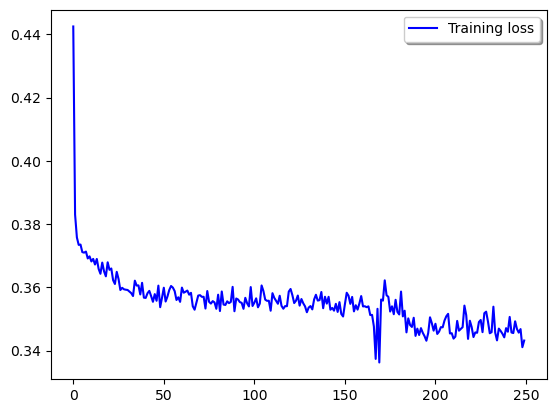

In [109]:
#Vamos ver como foi o treino?
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], color='b', label="Training loss")
legend = plt.legend(loc='best', shadow=True)

In [110]:
import numpy as np

results_train = model.evaluate(X_train, y_train, verbose = 0)
y_hat_train = model.predict(X_train)
y_hat_train = [np.max(y) for y in y_hat_train]
error_train = y_hat_train - y_train
print('train loss, test acc:', results_train)


results_test = model.evaluate(X_test, y_test, verbose = 0)
y_hat_test = model.predict(X_test)
y_hat_test = [np.max(y) for y in y_hat_test]
error_test = y_hat_test - y_test

print('test loss, test acc:', results_test)

19/19 [==============================] - 0s 2ms/step
train loss, test acc: 0.34235572814941406
10/10 [==============================] - 0s 2ms/step
test loss, test acc: 0.40339386463165283


## Implement ICoNet

#### Prepare data

In [111]:
# Train df
X_train_V = X_train.copy()  
X_train_V['error'] = error_train
X_train_V['Survived'] = y_train


# Test df
X_test_V = X_test.copy()
X_test_V['error'] = error_test
X_test_V['Survived'] = y_test


In [112]:
df_encoder_train = X_train_V.copy()
df_outs_train = df_encoder_train['Survived']
df_features_train = df_encoder_train.drop(['error','Survived'], axis = 1)



df_encoder_test = X_test_V.copy()
df_outs_test = df_encoder_test['Survived']
df_features_test = df_encoder_test.drop(['error','Survived'], axis = 1)

In [113]:
encoding_dim = 1
number_of_features = len(df_encoder_train.columns)


#### Run Iconet

In [114]:
import numpy as np # linear algebra
from numpy.random import seed
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from keras.layers import Input, Dense, concatenate
from keras.models import Model
from tensorflow.python.client import device_lib
import keras
from keras import optimizers
from keras.layers import LeakyReLU

##### Training

In [120]:

keras.backend.clear_session()
input_dim = Input(shape = (number_of_features, ))
input_dim2 = Input(shape = (number_of_features - 2, ))
# Encoder Layers
model.add(BatchNormalization())
encoded1 = Dense(40, activation = 'relu')(input_dim)
model.add(BatchNormalization())
encoded2 = Dense(20, activation = 'relu')(encoded1)
model.add(BatchNormalization())
encoded5 = Dense(5, activation = 'relu')(encoded2)
encoded13 = Dense(encoding_dim, activation = 'linear')(encoded5)
merged = keras.layers.concatenate([encoded13, input_dim2], axis=-1)
# Decoder Layers
model.add(BatchNormalization())
decoded1 = Dense(100, activation = 'relu')(merged)
model.add(BatchNormalization())
decoded2 = Dense(500, activation = 'relu')(decoded1)
model.add(BatchNormalization())
decoded3 = Dense(500, activation = 'relu')(decoded2)
model.add(BatchNormalization())
decoded4 = Dense(250, activation = 'relu')(decoded3)
model.add(BatchNormalization())
decoded5 = Dense(50, activation = 'relu')(decoded4)


decoded13 = Dense(2, activation = 'sigmoid')(decoded4)

# Combine Encoder and Deocder layers
counter = Model(inputs = [input_dim, input_dim2], outputs = [decoded13])


optimizer = keras.optimizers.Nadam(learning_rate= 0.0001)
# Compile the Model
counter.compile(optimizer = 'adam', loss = 'mean_absolute_error')

In [121]:
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1000,
                              verbose=0, mode='auto',
                                  restore_best_weights=True)


callbacks = [es]

history = counter.fit(x = [df_encoder_train, df_features_train], y = df_outs_train, epochs = 500, 
                batch_size = 128, shuffle = True,
                validation_data=([df_encoder_test,df_features_test],df_outs_test),
               #callbacks = callbacks
                
               )

Epoch 1/500
5/5 [==============================] - 2s 73ms/step - loss: 0.3932 - val_loss: 0.4067
Epoch 2/500
5/5 [==============================] - 0s 18ms/step - loss: 0.3726 - val_loss: 0.4068
Epoch 3/500
5/5 [==============================] - 0s 19ms/step - loss: 0.3725 - val_loss: 0.4068
Epoch 4/500
5/5 [==============================] - 0s 22ms/step - loss: 0.3725 - val_loss: 0.4068
Epoch 5/500
5/5 [==============================] - 0s 19ms/step - loss: 0.3725 - val_loss: 0.4068
Epoch 6/500
5/5 [==============================] - 0s 18ms/step - loss: 0.3725 - val_loss: 0.4068
Epoch 7/500
5/5 [==============================] - 0s 17ms/step - loss: 0.3725 - val_loss: 0.4068
Epoch 8/500
5/5 [==============================] - 0s 20ms/step - loss: 0.3725 - val_loss: 0.4068
Epoch 9/500
5/5 [==============================] - 0s 18ms/step - loss: 0.3725 - val_loss: 0.4068
Epoch 10/500
5/5 [==============================] - 0s 17ms/step - loss: 0.3725 - val_loss: 0.4068
Epoch 11/500
5/5 [=

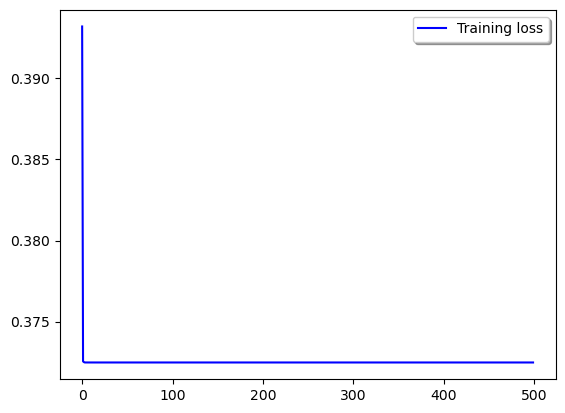

In [122]:
#Vamos ver como foi o treino?
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], color='b', label="Training loss")
legend = plt.legend(loc='best', shadow=True)

In [118]:
counter = Model(inputs = [input_dim,input_dim2], outputs = decoded13)
encoded_input = Input(shape = (encoding_dim, ))

encoded_test = pd.DataFrame(counter.predict([df_encoder_test,df_features_test]))
encoded_test = encoded_test.add_prefix('feature_')


10/10 [==============================] - 0s 3ms/step


## End

In [119]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mean_absolute_error(encoded_test['feature_0'], df_outs_test['Survived'])

KeyError: 'Survived'

In [ ]:
from sklearn.metrics import r2_score
r2_score(encoded_test['feature_0'], df_outs_test['Survived'])

KeyError: 'Survived'